# 第5章 検索システムの評価

In [1]:
# これまでに定義した関数の読み込み

from chapter01 import get_string_from_file
from chapter02 import get_words_from_file
from chapter03 import get_words, bows_to_cfs, load_aozora_corpus, get_bows,\
    add_to_corpus, get_weights, translate_bows, get_tfidfmodel_and_weights
from chapter04 import vsm_search

%matplotlib inline

## 5.2 適合率と再現率

In [2]:
# Listing 5.1 #

right_answer = [0, 1, 0, 1, 0, 1, 0, 0, 1, 1]

In [3]:
# Listing 5.2 #

from pprint import pprint

# 書籍紹介のデータを読み込む
book_texts = [get_string_from_file('data/ch05/%d.txt' % i) for i in range(0,10)]        
query = '人工知能'

result = vsm_search(book_texts, query)
pprint(result)

[(1, 0.7481151),
 (8, 0.6076249),
 (5, 0.31722325),
 (0, 0.21160641),
 (2, 0.18004589),
 (3, 0.0),
 (4, 0.0),
 (6, 0.0),
 (7, 0.0),
 (9, 0.0)]


In [4]:
# Listing 5.3 #

def select_by_threshold(r, threshold=0.0):
    # rの長さ分の0を要素とするリストを作成
    answer = [0]*len(r)
    for i in r:
        # 類似度がthresholdより大きいときr[文書番号]を1にする
        if i[1] > threshold: answer[i[0]] = 1
    return answer

In [5]:
# Listing 5.4 #

# デフォルト値0.0を閾値として採否を判断
my_answer = select_by_threshold(result, threshold=0)
# 正解と並べて表示
print('right_answer = {}'.format(right_answer))
print('my_answer    = {}'.format(my_answer))

right_answer = [0, 1, 0, 1, 0, 1, 0, 0, 1, 1]
my_answer    = [1, 1, 1, 0, 0, 1, 0, 0, 1, 0]


In [6]:
# Listing 5.5 #

from sklearn.metrics import precision_score, recall_score, f1_score

def print_scores(right_answer, my_answer):
    print('precision %.4f' % precision_score(right_answer, my_answer))
    print('recall %.4f' % recall_score(right_answer, my_answer))   
    print('f-measure %.4f' % f1_score(right_answer, my_answer))

In [7]:
# Listing 5.6 #

print_scores(right_answer, my_answer)

precision 0.6000
recall 0.6000
f-measure 0.6000


In [8]:
# Listing 5.7 #

my_answer = select_by_threshold(result, threshold=0.3)
print('my_answer = {}'.format(my_answer))
print_scores(right_answer, my_answer)

my_answer = [0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
precision 1.0000
recall 0.6000
f-measure 0.7500


In [9]:
# Listing 5.8 #

print(get_words(query))

['人工', '知能']


## 5.3 適合率-再現率曲線

In [10]:
# Listing 5.9 #

my_ranking = tuple([x[0] for x in result])
print(my_ranking)

(1, 8, 5, 0, 2, 3, 4, 6, 7, 9)


In [11]:
# Listing 5.10 #

# str()で数値を文字列に変換し，''.join()で結合する
print(''.join([str(right_answer[i]) for i in my_ranking]))

1110010001


In [12]:
# Listing 5.11 #

# クエリに適合する文書のリスト
matching = [i for i, x in enumerate(right_answer) if x == 1]
# 適合しない文書のリスト
non_matching = [i for i, x in enumerate(right_answer) if x == 0]

# 理想的なランキング
good_ranking = tuple(matching + non_matching)
print(good_ranking)
print(''.join([str(right_answer[i]) for i in good_ranking]))

(1, 3, 5, 8, 9, 0, 2, 4, 6, 7)
1111100000


In [13]:
# Listing 5.12 #

def top_n(r, n):
    answer = [0]*len(r)
    for i in range(n):
        answer[r[i]] = 1
    return answer

In [14]:
# Listing 5.13 #

n = 2
my_answer_n = top_n(my_ranking, n)
print(my_answer_n)
print(recall_score(right_answer, my_answer_n))
print(precision_score(right_answer, my_answer_n))

[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
0.4
1.0


In [15]:
# Listing 5.14 #

def get_pr_curve(ranking, answer):
    # top_n(ranking, i)の適合率と再現率をそれぞれprecision[i]とrecall[i]へ
    # precision[0] = 1, recall[0] = 0とする
    precision = [1]
    recall = [0]
    for i in range(1, len(ranking) + 1):
        x = top_n(ranking, i)
        precision.append(precision_score(answer, x))
        recall.append(recall_score(answer, x))
    return precision, recall

In [16]:
# Listing 5.15 #
                                                             
import matplotlib.pyplot as plt
%matplotlib inline

def draw_pr_curve(ranking, answer):
    precision, recall = get_pr_curve(ranking, answer)
    # グラフの描画範囲を設定
    plt.xlim(-0.05, 1.05)
    plt.ylim(0.0, 1.1)
    # 各軸のラベルを設定．x軸に再現率，Y軸に適合率
    plt.xlabel('recall')
    plt.ylabel('precision')
    # 曲線の下を塗りつぶす
    plt.fill_between(recall, precision, 0, facecolor='#FFFFCC')
    # 曲線を点と線で描く
    plt.plot(recall, precision, 'o-')

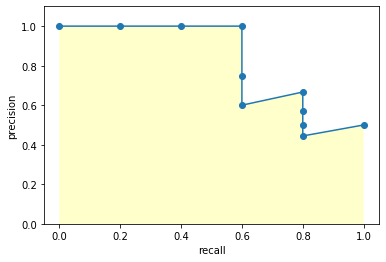

In [17]:
# Listing 5.16 #

draw_pr_curve(my_ranking, right_answer)

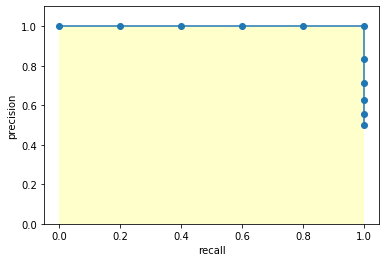

In [18]:
# Listing 5.17 #

draw_pr_curve(good_ranking, right_answer)

In [19]:
# Listing 5.18 #

def get_average_precision(ranking, answer):
    precision, recall = get_pr_curve(ranking, answer)
    ap = 0.0
    # (r[i-1], 0), (r[i-1], p[i-1]), (r[i], 0), (r[i], p[i]) で
    # 囲まれる面積をそれぞれap に加算
    for i in range(1, len(precision)):
        ap += (recall[i] - recall[i -1])*(precision[i -1] + precision[i])/2.0
    return ap

In [20]:
# Listing 5.19 #

print('my_ranking   %.4f' % get_average_precision(my_ranking, right_answer))
print('good_ranking %.4f' % get_average_precision(good_ranking, right_answer))

my_ranking   0.8211
good_ranking 1.0000
